In [1]:
import scipy
from scipy import misc
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import pandas as pd
import numpy as np
from os import path, makedirs, listdir
from os.path import isfile, join, exists
import glob
from skimage.transform import resize
from astropy.visualization import make_lupton_rgb

In [2]:
def clip_galaxy_imgs(xwin, ywin, tilename, band, rad, image_path, dim=2):
    """
    Extract a small square image containing the target galaxy from a large telescope image.
    
    Parameters:
    image_path -- path to the input FITS file. This assumes the image data is contained in
                 the 1st entry of the FITS file.
    dim        -- the size of the bounding box in unit of `side_length / galaxy_diameter`.
    
    Returns:
    The clipped galaxy image as a 2d numpy array.
    """

    fits_path = glob.glob( image_path.format(tilename = tilename, band=band) )[0]
    image_file = fits.open(fits_path)
    image_data = image_file[1].data

    #cc, rc = main_entry.XWIN_IMAGE, image_data.shape[0] - main_entry.YWIN_IMAGE
    cc, rc = xwin, ywin

    rs, re = [rc + sign * dim * rad for sign in (-1, 1)]
    cs, ce = [cc + sign * dim * rad for sign in (-1, 1)]
    rs, re, cs, ce = [int(round(x)) for x in (rs, re, cs, ce)]

    clip = image_data[rs:re, cs:ce]
    return clip


def rescale(img_in):

    img = img_in.astype('float')
    img_bg_sorted = np.sort(img)[:img.size // 2]
    img_bg_std = img_bg_sorted.std()
    img_bg_mean = img_bg_sorted.mean()
    img_min = - img_bg_std + img_bg_mean
    img_max = img_bg_std * 5 + img_bg_mean
    img_scaled = (img - img_min) / (img_max - img_min)
    img_scaled[img_scaled < 0] = 0
    img_scaled[img_scaled > 1] = 1
    out = img_scaled

    return out


def merge_pseudocolor(r,g,i):
    nrows, ncols = 200, 200
    rgb = np.empty((nrows, ncols, 3))
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = i
    rgb = (rgb * 255).astype('uint8')
    return rgb


In [3]:
if __name__ == '__main__':
    
    # Pull up database
    PATH = '/home/khan74/project/priv/new_DL_DES/'
    full_overlap_crossmatch_test_set = pd.read_csv( PATH + 'deeplearning/data/full_overlap_crossmatch_test_set.csv')
    merged_cm = full_overlap_crossmatch_test_set

    # Create/Save rgb clipped images 
    tgt_dim = (200, 200)
    bands = ['g','i','r','Y','z']
    
    
    des_image_path = PATH + 'data/des/des_sdss_overlap/full_overlap/raw/{tilename}_*_{band}.fits.fz'
    out_dir = PATH + 'data/des/des_sdss_overlap/full_overlap/images/'


    for i in merged_cm.index[200:] :

        tilename = merged_cm['TILENAME'][i]
        COADD_OBJECT_ID = merged_cm['DES_COADD_OBJECT_ID'][i]
        xwin = merged_cm['XWIN_IMAGE'][i]
        ywin = merged_cm['YWIN_IMAGE'][i]
        rad = merged_cm['KRON_RADIUS'][i]

        try:
            for band in bands:
                exec('data_%s'%band + ' = clip_galaxy_imgs(xwin, ywin, tilename, band, rad, des_image_path, dim=12)')

            in_ds = [data_g, data_i, data_r]
            out_ds = {k: resize(in_ds[k].astype('float'), tgt_dim)
                          for k in range(len(in_ds))}

            resized_g, resized_i, resized_r = out_ds[0], out_ds[1], out_ds[2]
            remapped_g, remapped_i, remapped_r = rescale(resized_g), rescale(resized_i), rescale(resized_r)

            #image = make_lupton_rgb(remapped_i, remapped_r, remapped_g, Q=1, stretch=1)
            image = merge_pseudocolor(remapped_r, remapped_g, remapped_i)

        except:
            print('FAILED:', COADD_OBJECT_ID)
            continue

        out_file = path.join(out_dir, '%s.png' % COADD_OBJECT_ID)
        #scipy.misc.imsave(out_file, image)
        break

/home/khan74/.conda/envs/AI/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/khan74/.conda/envs/AI/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'remapped i')

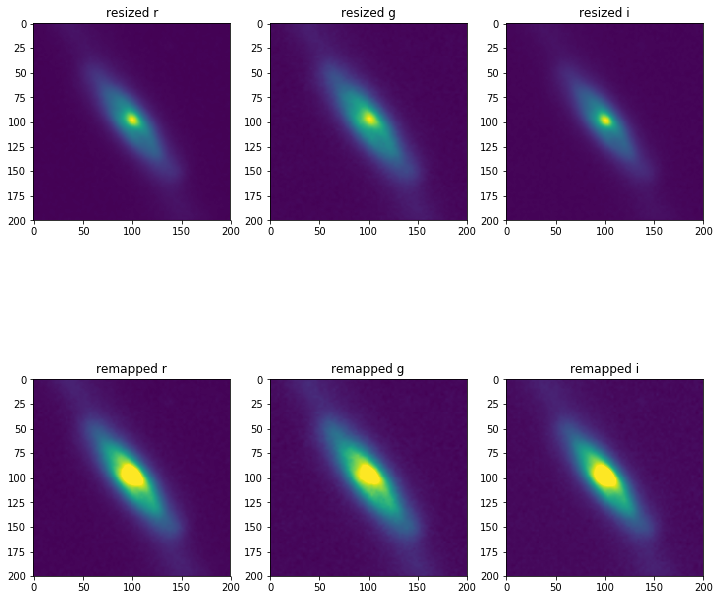

In [5]:
plt.figure( figsize=(12,12) )

plt.subplot(2,3,1)
plt.imshow(resized_r)
plt.title('resized r')

plt.subplot(2,3,2)
plt.imshow(resized_g)
plt.title('resized g')

plt.subplot(2,3,3)
plt.imshow(resized_i)
plt.title('resized i')


plt.subplot(2,3,4)
plt.imshow(remapped_r)
plt.title('remapped r')

plt.subplot(2,3,5)
plt.imshow(remapped_g)
plt.title('remapped g')

plt.subplot(2,3,6)
plt.imshow(remapped_i)
plt.title('remapped i')

Text(0.5, 1.0, 'stack remapped')

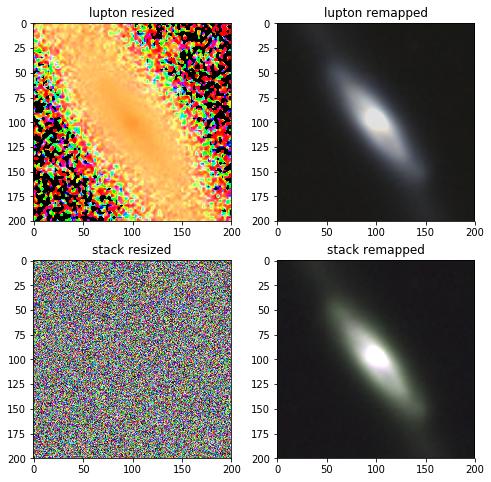

In [6]:
plt.figure(figsize=(8,8) )

plt.subplot(2,2,1)
image_lup_resized = make_lupton_rgb(resized_i, resized_r, resized_g, Q=1, stretch=1)
plt.imshow(image_lup_resized)
plt.title('lupton resized')

plt.subplot(2,2,2)
image_lup_remapped = make_lupton_rgb(remapped_i, remapped_r, remapped_g, Q=1, stretch=1)
plt.imshow(image_lup_remapped)
plt.title('lupton remapped')

plt.subplot(2,2,3)
image_stack_resized = merge_pseudocolor(resized_r, resized_g, resized_i)
plt.imshow(image_stack_resized)
plt.title('stack resized')

plt.subplot(2,2,4)
image_stack_remapped = merge_pseudocolor(remapped_r, remapped_g, remapped_i)
plt.imshow(image_stack_remapped)
plt.title('stack remapped')